# ASPIRE ab initio pipeline -- simulated data

In [ ]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.proposals import CryoProposals
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.projection import project

import jax
import mrcfile
from jax.scipy.special import gammaln

plt.rcParams["figure.figsize"]=6,6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from aspire.abinitio import CLSyncVoting
from aspire.basis import FFBBasis2D, FFBBasis3D
from aspire.classification import BFSReddyChatterjiAverager2D, RIRClass2D
from aspire.denoising import DenoiserCov2D
from aspire.noise import AnisotropicNoiseEstimator
from aspire.operators import FunctionFilter, RadialCTFFilter
from aspire.reconstruction import MeanEstimator
from aspire.source import Simulation
from aspire.utils.coor_trans import (
    get_aligned_rotations,
    get_rots_mse,
    register_rotations,
)
from aspire.volume import Volume

logger = logging.getLogger(__name__)


### Parameters

In [303]:
interactive = True  # Draw blocking interactive plots?
do_cov2d = False  # Use CWF coefficients
img_size = 32  # Downsample the volume to a desired resolution
num_imgs = 1000  # How many images in our source.
n_classes = 100  # How many class averages to compute.
n_nbor = 10  # How many neighbors to stack
noise_variance = 5e-7  # Set a target noise variance
out_dir = "../data/out_dev" # Directory to print volumes to
save_to_file = True


### Simulation data

In [321]:
vol_file = "/home/bt387/project/simple_cryoem/data/emdb/emd_2660.map"

og_v = Volume.load(vol_file, dtype=np.float64)
logger.info("Original volume map data" f" shape: {og_v.shape} dtype:{og_v.dtype}")

2022-06-17 13:54:57,307 INFO /home/bt387/project/simple_cryoem/data/emdb/emd_2660.map with dtype float32 loaded as <class 'numpy.float64'>
2022-06-17 13:54:57,416 INFO Original volume map data shape: (1, 360, 360, 360) dtype:float64


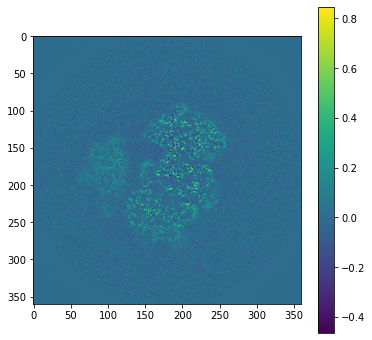

In [322]:
plt.imshow(og_v[0,180]); plt.colorbar()

In [323]:
logger.info(f"Downsampling to {(img_size,)*3}")
v = og_v.downsample(img_size)
L = v.resolution

2022-06-17 13:54:57,646 INFO Downsampling to (32, 32, 32)


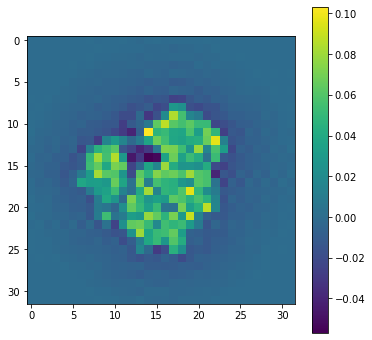

In [324]:
plt.imshow(v[0,16]); plt.colorbar()

In [8]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v.mrc', overwrite=True) as mrc:
        mrc.set_data(og_v._data.astype(np.float32))

In [9]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v_downsampled.mrc', overwrite=True) as mrc:
        mrc.set_data(v._data.astype(np.float32))

In [10]:
# Then create a filter based on that variance
# This is an example of a custom noise profile
def noise_function(x, y):
    alpha = 1
    beta = 1
    # White
    f1 = noise_variance
    # Violet-ish
    f2 = noise_variance * (x * x + y * y) / L * L
    return (alpha * f1 + beta * f2) / 2.0


custom_noise_filter = FunctionFilter(noise_function)

In [812]:
logger.info("Initialize CTF filters.")
# Create some CTF effects
pixel_size = 5 * 65 / img_size  # Pixel size of the images (in angstroms)
voltage = 200  # Voltage (in KV)
defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
defocus_ct = 7  # Number of defocus groups.
Cs = 2.0  # Spherical aberration
alpha = 0.1  # Amplitude contrast

# Create filters
ctf_filters = [
    RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]



2022-06-17 15:33:35,369 INFO Initialize CTF filters.


In [768]:
src._metadata

,_rlnClassNumber,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi,_rlnVoltage,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle,_rlnSphericalAberration,_rlnAmplitudeContrast,__filter_indices,_rlnOriginX,_rlnOriginY,_rlnAmplitude
0,1,30.000000,45.000000,90.000000,200.0,18333.33,18333.33,0.0,2.0,0.1,0,-5.400000,6.800000,1.345603
1,1,-33.914909,106.849129,-38.783825,200.0,18333.33,18333.33,0.0,2.0,0.1,0,-2.281502,2.723681,1.421493
2,1,45.715252,6.276152,87.337212,200.0,18333.33,18333.33,0.0,2.0,0.1,0,0.676217,-2.591389,0.772489
3,1,-31.184692,123.480759,46.654907,200.0,18333.33,18333.33,0.0,2.0,0.1,0,-1.174617,0.235573,1.427813
4,1,-132.350662,72.247719,81.024429,200.0,18333.33,18333.33,0.0,2.0,0.1,0,3.444919,3.620940,1.193633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,-131.161896,161.749969,-109.235252,200.0,18333.33,18333.33,0.0,2.0,0.1,0,0.625701,1.659251,1.196384
996,1,-17.678020,99.854233,23.270672,200.0,18333.33,18333.33,0.0,2.0,0.1,0,1.323130,-2.295497,1.459079
997,1,159.827087,62.431095,-90.841835,200.0,18333.33,18333.33,0.0,2.0,0.1,0,1.849054,-3.914791,1.036637
998,1,21.606775,55.753944,151.344147,200.0,18333.33,18333.33,0.0,2.0,0.1,0,-0.432334,1.234151,0.716682


In [769]:
src.filter_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

2022-06-17 15:18:27,008 INFO Creating Simulation with 1000 images.
2022-06-17 15:18:27,012 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-17 15:18:27,030 INFO Creating Simulation with 1000 images.
2022-06-17 15:18:27,031 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-17 15:18:27,042 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 15:18:27,044 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 15:18:27,076 INFO Applying forward transformations in pipeline
2022-06-17 15:18:27,076 INFO All forward transformations applied
2022-06-17 15:18:27,079 INFO Loaded 10 images


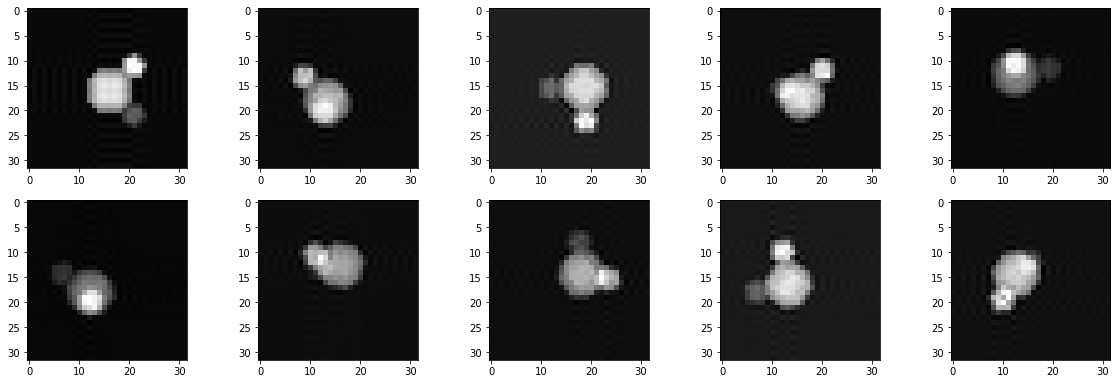

In [732]:
# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_filter= None, #custom_noise_filter,
    unique_filters= None, #ctf_filters,
)

angles = src.angles
shifts = src.offsets

angles[0] = [0,0,0]
shifts[0] = [0,0]

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    angles = angles,
    offsets = shifts,
    noise_filter= None, #custom_noise_filter,
    unique_filters= None, #ctf_filters,
)
# Peek
if interactive:
    src.images(0, 10).show()

In [796]:
# Use phase_flip to attempt correcting for CTF.
logger.info("Perform phase flip to input images.")
#src.phase_flip()


2022-06-17 15:29:00,847 INFO Perform phase flip to input images.


In [694]:
# Estimate the noise and `Whiten` based on the estimated noise
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
#src.whiten(aiso_noise_estimator.filter)

2022-06-17 15:06:06,557 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 15:06:06,564 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 15:06:06,772 INFO Applying forward transformations in pipeline
2022-06-17 15:06:06,773 INFO All forward transformations applied
2022-06-17 15:06:06,773 INFO Loaded 512 images
2022-06-17 15:06:06,785 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 15:06:06,788 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 15:06:06,980 INFO Applying forward transformations in pipeline
2022-06-17 15:06:06,981 INFO All forward transformations applied
2022-06-17 15:06:06,981 INFO Loaded 488 images


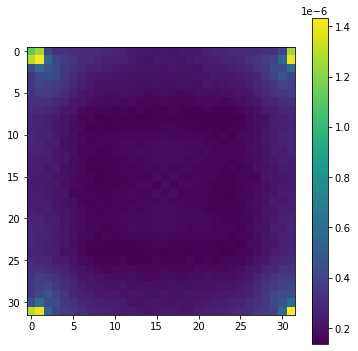

2022-06-17 15:06:08,178 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 15:06:08,179 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 15:06:08,206 INFO Applying forward transformations in pipeline
2022-06-17 15:06:08,207 INFO All forward transformations applied
2022-06-17 15:06:08,207 INFO Loaded 10 images


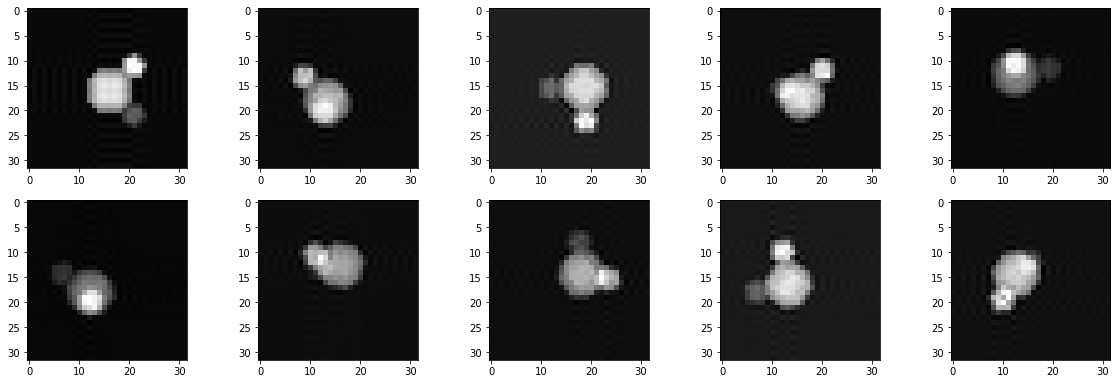

In [695]:
# Plot the noise profile for inspection
if interactive:
    plt.imshow(aiso_noise_estimator.filter.evaluate_grid(L))
    plt.colorbar()
    plt.show()

# Peek, what do the whitened images look like...
if interactive:
    src.images(0, 10).show()

In [696]:
# Cache to memory for some speedup
src.cache()

2022-06-17 15:06:11,136 INFO Caching source images
2022-06-17 15:06:11,138 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 15:06:11,146 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 15:06:11,529 INFO Applying forward transformations in pipeline
2022-06-17 15:06:11,530 INFO All forward transformations applied
2022-06-17 15:06:11,531 INFO Loaded 1000 images


### Class Averaging

In [ ]:
logging.disable(logging.INFO)

In [ ]:
logger.info("Begin Class Averaging")

rir = RIRClass2D(
    src,  # Source used for classification
    fspca_components=400,
    bispectrum_components=300,  # Compressed Features after last PCA stage.
    n_nbor=n_nbor,
    n_classes=n_classes,
    large_pca_implementation="legacy",
    nn_implementation="sklearn",
    bispectrum_implementation="legacy",
    averager=None,
)

classes, reflections, distances = rir.classify()
avgs = rir.averages(classes, reflections, distances)
if interactive:
    avgs.images(0, 10).show()

### Common Line Estimation

In [ ]:
logger.info("Begin Orientation Estimation")

# Stash true rotations for later comparison,
#   note this line only works with naive class selection...
true_rotations = src.rots[:n_classes]

orient_est = CLSyncVoting(avgs, n_theta=36)
# Get the estimated rotations
orient_est.estimate_rotations()
rots_est = orient_est.rotations

logger.info("Compare with known rotations")
# Compare with known true rotations
Q_mat, flag = register_rotations(rots_est, true_rotations)
regrot = get_aligned_rotations(rots_est, Q_mat, flag)
mse_reg = get_rots_mse(regrot, true_rotations)
logger.info(
    f"MSE deviation of the estimated rotations using register_rotations : {mse_reg}\n"
)

### Volume reconstruction

In [ ]:
logger.info("Begin Volume reconstruction")

# Assign the estimated rotations to the class averages
avgs.rots = rots_est

# Create a reasonable Basis for the 3d Volume
basis = FFBBasis3D((v.resolution,) * 3, dtype=v.dtype)

# Setup an estimator to perform the back projection.
estimator = MeanEstimator(avgs, basis)

# Perform the estimation and save the volume.
estimated_volume = estimator.estimate()
fn = f"estimated_volume_n{num_imgs}_c{n_classes}_m{n_nbor}_{img_size}.mrc"
estimated_volume.save(fn, overwrite=True)

# Peek at result
if interactive:
    plt.imshow(np.sum(estimated_volume[0], axis=-1))
    plt.show()

In [ ]:
if save_to_file:
    with mrcfile.new(out_dir + '/rec_aspire.mrc', overwrite=True) as mrc:
        mrc.set_data(estimated_volume._data.astype(np.float32))

### Aspire vs JaxEM

Text(0.5, 1.0, 'Volume_comp MIP')

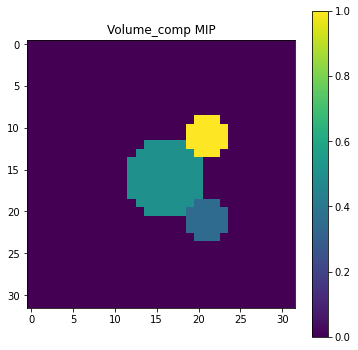

In [784]:
shape = np.array([nx,nx,nx])
dimensions = pixel_size * shape

# A volume with components
centres = np.array([[0,0,0], [0.1, 0.1, 0], [0.1, -0.1, 0]]) * 500
radii = np.array([0.1, 0.05, 0.05]) * 500
intensities = np.array([10,7,20])

myv = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False, sigma = 0.1))
mip_z(myv)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

In [785]:
src.projections

<bound method Simulation.projections of <aspire.source.simulation.Simulation object at 0x2b1700d4da20>>

In [797]:
angles[0] = [jnp.pi/6,jnp.pi/4, jnp.pi/2]
shifts[0] = [-5.4, 6.8]

v._data = np.array([myv])

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    angles = angles,
    offsets = shifts,
    noise_filter= None, #custom_noise_filter,
    unique_filters= ctf_filters,
)
src.phase_flip()


N = 100
nx = img_size

vol = jnp.array(v._data[0])
vol_f, x_grid, _ = volume_fourier(v._data[0], pixel_size)
imgs = jnp.array(src.images(0,N).data)
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs])
angles = src.angles # "_rlnAngleRot", "_rlnAngleTilt", "_rlnAnglePsi" in radians -> I store psi, tilt,rot
shifts = src.offsets

print(f"x_grid = {x_grid}")

2022-06-17 15:29:13,023 INFO Creating Simulation with 1000 images.
2022-06-17 15:29:13,024 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-17 15:29:13,039 INFO Perform phase flip on source object
2022-06-17 15:29:13,039 INFO Adding Phase Flip Xform to end of generation pipeline
2022-06-17 15:29:13,059 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 15:29:13,062 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 15:29:13,125 INFO Applying forward transformations in pipeline
2022-06-17 15:29:13,127 INFO   Applying IndexedXform
2022-06-17 15:29:13,131 INFO All forward transformations applied
2022-06-17 15:29:13,133 INFO Loaded 100 images
x_grid = [3.07692308e-03 3.20000000e+01]


In [798]:
angles[0]

array([0.5235988, 0.7853982, 1.5707964], dtype=float32)

In [821]:
myshifts = jnp.array([shifts[0,1], shifts[0,0]]) * pixel_size # This seems correct
myangles = -jnp.array([angles[0,2], angles[0,1], angles[0,0]])
myctf_params = jnp.array(
    [jnp.array([f.defocus_u, f.defocus_v, f.defocus_ang, 0, f.voltage, f.alpha, f.Cs, 0, 2*pixel_size]) for f in ctf_filters]
)[0]

Text(0.5, 1.0, 'my projection')

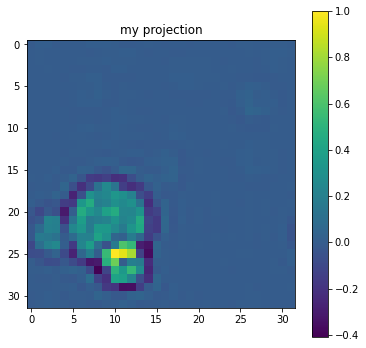

In [822]:
pr = project_spatial(vol, myangles, pixel_size, myshifts, ctf_params= myctf_params)
pr = pr/jnp.max(pr)
plt.imshow(pr); plt.colorbar()
plt.title('my projection')

Text(0.5, 1.0, 'aspire')

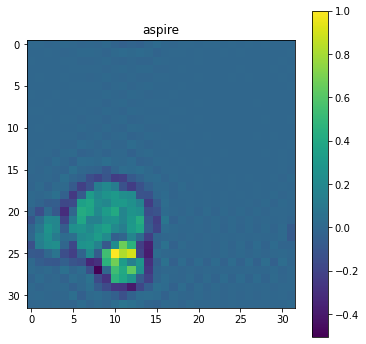

In [823]:
pr_a = imgs[0] /jnp.max(imgs[0])
plt.imshow(pr_a); plt.colorbar()
plt.title('aspire')

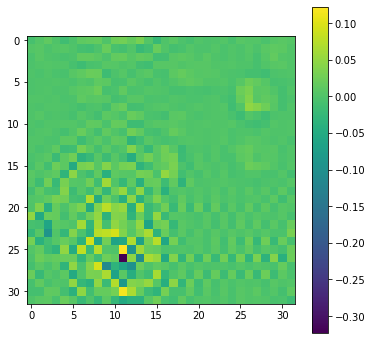

In [824]:
plt.imshow(pr-pr_a); plt.colorbar()